In [20]:
import json
from typing import Any, Dict, Iterable
from matplotlib import pyplot as plt
from matplotlib import axes
import numpy as np
import pyperf
from scipy import stats

In [21]:
def get_data(result: Dict[str, Any]) -> Dict[str, np.ndarray]:
    results = {}

    for benchmark in result["benchmarks"]:
        if "metadata" in benchmark:
            name = benchmark["metadata"]["name"]
        else:
            name = result["metadata"]["name"]
        data = []
        for run in benchmark["runs"]:
            data.extend(run.get("values", []))
        results[name] = np.array(data, dtype=np.float64)
        results[name].sort()

    return results

In [22]:
# Load data
run = "run5"

with open(f"results/{run}/run-1.json") as fb, open(f"results/{run}/run-2.json") as fh:
    base_raw = json.load(fb)
    head_raw = json.load(fh)

base = get_data(base_raw)
head = get_data(head_raw)

In [23]:
# Make sure that benchmarks match
if base.keys() != head.keys():
    raise Exception("The benchmarking suites are not the same size")

In [24]:
# Clean data
remove = []

for name in base.keys():
    sig, _ = pyperf._utils.is_significant(base[name], head[name])

    if not sig:
        remove.append(name)
    else:
        # Remove outliers
        base[name] = base[name][:45]
        head[name] = head[name][:45]

for name in remove:
    del base[name]
    del head[name]

In [30]:
def generate_histogram(ax: axes, name: str, data: Iterable, bins: int):
    ax.hist(data, bins=bins, color=['blue', 'green'], alpha=0.5, rwidth=0.5, align='left')
    ax.set_ylabel(name)
    ax.xaxis.set_major_formatter(lambda val, _: f"{val:.04f}s")

In [28]:
def generate_normal_dist(ax: axes, data: Iterable, num_bins: int, color: str):
    bin_width = (data.max() - data.min()) / num_bins
    
    x = np.linspace(data.min(), data.max(), len(data))
    print(x.min())
    print(x.max())
    print(data.min())
    print(data.max())
    ax.plot(x, stats.norm.pdf(x, x.mean(), x.std()) * len(x) * bin_width, color=color)

0.02772742024899344
0.03002696125076909
0.02772742024899344
0.03002696125076909
0.026943115501126158
0.029688230499232304
0.026943115501126158
0.029688230499232304


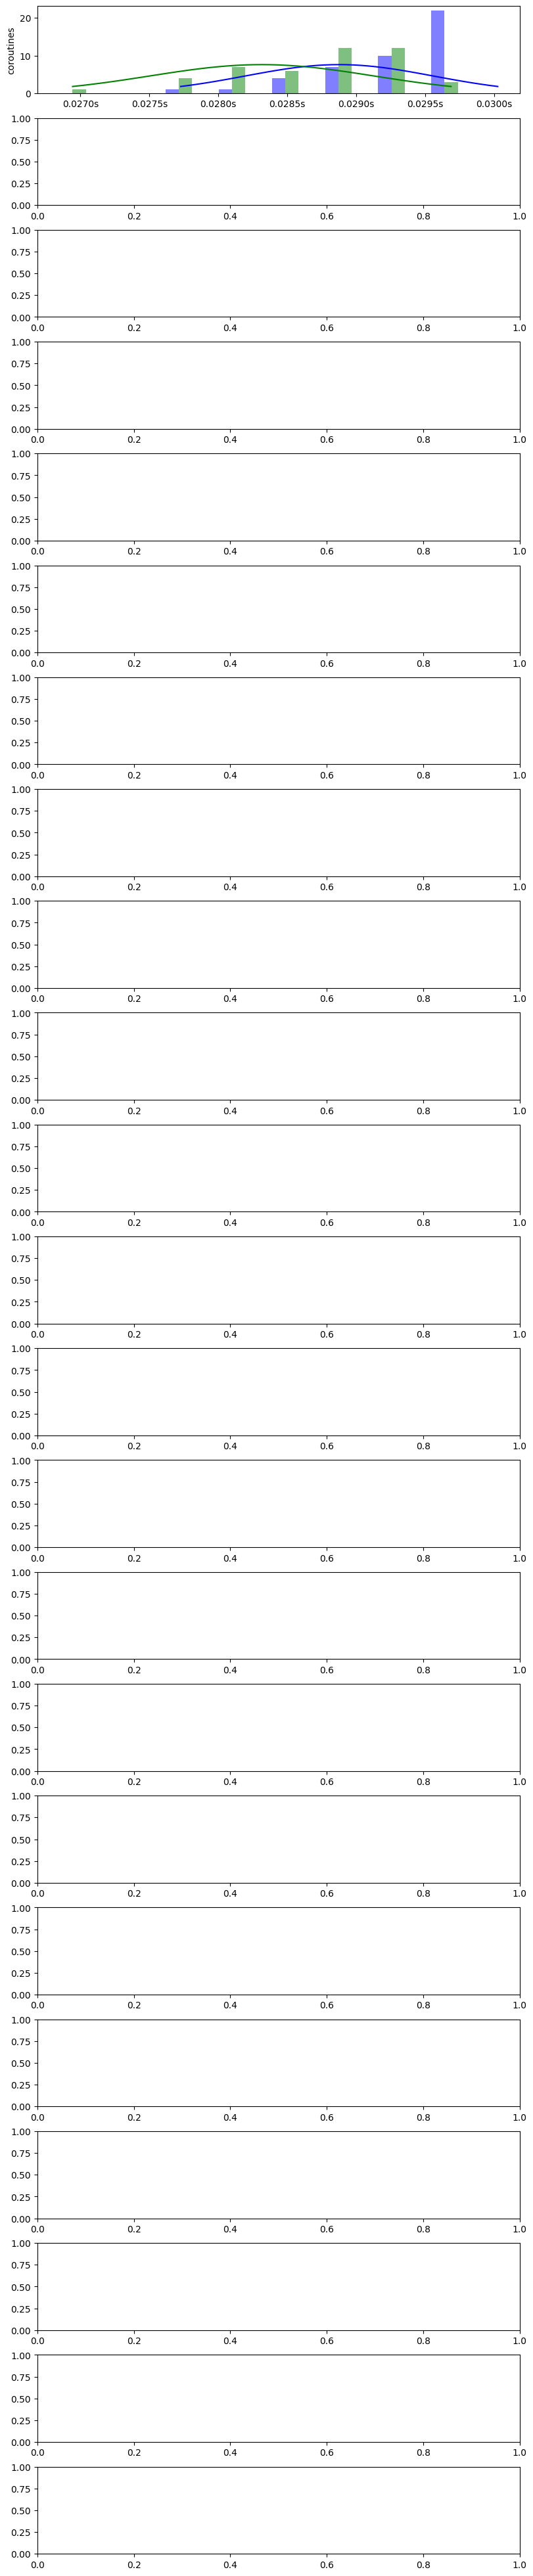

In [31]:
# _, axs = plt.subplots(2, figsize=(8, 4), layout="constrained")
_, axs = plt.subplots(len(base), figsize=(8, len(base) * 1.7), layout="constrained")

num_bins = 8

ax_counter = 0
for k in base.keys():
    b_v = base[k]
    h_v = head[k]

    generate_histogram(axs[ax_counter], k, [b_v, h_v], num_bins)

    generate_normal_dist(axs[ax_counter], b_v, num_bins, "blue")
    generate_normal_dist(axs[ax_counter], h_v, num_bins, "green")

    ax_counter += 1
    break

plt.show()
